In [1]:
#0 원본 데이터 압축 해제 및 label, raw 디렉토리 생성 (Test 구조 포함)
import os
import shutil
import zipfile

# ========= 설정 =========
PROJECT_ROOT = os.getcwd()
RAW_DATA_ROOT = os.path.join(PROJECT_ROOT, "raw_data")

TRAIN_DIR = os.path.join(RAW_DATA_ROOT, "Training")
TEST_DIR  = os.path.join(RAW_DATA_ROOT, "Test")

TRAIN_ZIP = os.path.join(TRAIN_DIR, "Training_data.zip")
TEST_LABEL_ZIP = os.path.join(TEST_DIR, "TL_1_조합.zip")
TEST_RAW_ZIP   = os.path.join(TEST_DIR, "TS_1_조합.zip")

TRAIN_LABEL_DIR = os.path.join(TRAIN_DIR, "label")
TRAIN_RAW_DIR   = os.path.join(TRAIN_DIR, "raw")

TEST_LABEL_DIR = os.path.join(TEST_DIR, "label")
TEST_RAW_DIR   = os.path.join(TEST_DIR, "raw")


# ========= 유틸 =========
def unzip(zip_path, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(dst_dir)

def rm_dir(path):
    if os.path.isdir(path):
        shutil.rmtree(path)

def mv(src, dst):
    if os.path.exists(dst):
        rm_dir(dst) if os.path.isdir(dst) else os.remove(dst)
    os.rename(src, dst)

def flatten_if_single_subdir(dst_dir):
    items = [p for p in os.listdir(dst_dir) if p not in [".DS_Store"]]
    if len(items) == 1:
        only = os.path.join(dst_dir, items[0])
        if os.path.isdir(only):
            for name in os.listdir(only):
                shutil.move(os.path.join(only, name), os.path.join(dst_dir, name))
            rm_dir(only)


# ========= 1) Training_data.zip 처리 =========
def setup_training():
    unzip(TRAIN_ZIP, TRAIN_DIR)
    flatten_if_single_subdir(TRAIN_DIR)

    rm_dir(os.path.join(TRAIN_DIR, "test_images"))

    src_anno = os.path.join(TRAIN_DIR, "train_annotations")
    dst_label = os.path.join(TRAIN_DIR, "label")
    if os.path.isdir(src_anno):
        mv(src_anno, dst_label)

    src_imgs = os.path.join(TRAIN_DIR, "train_images")
    dst_raw = os.path.join(TRAIN_DIR, "raw")
    if os.path.isdir(src_imgs):
        mv(src_imgs, dst_raw)

    print("[OK] Training setup done")


# ========= 2) Test zip 처리 =========
def setup_test():
    label_dir = os.path.join(TEST_DIR, "label")
    rm_dir(label_dir)
    unzip(TEST_LABEL_ZIP, label_dir)
    flatten_if_single_subdir(label_dir)

    raw_dir = os.path.join(TEST_DIR, "raw")
    rm_dir(raw_dir)
    unzip(TEST_RAW_ZIP, raw_dir)
    flatten_if_single_subdir(raw_dir)

    print("[OK] Test setup done")


if __name__ == "__main__":
    setup_training()
    setup_test()

[OK] Training setup done
[OK] Test setup done


In [2]:
#1. (NEW POLICY) PNG(혼합 1장) ↔ JSON(약재별 여러개) 매칭 인덱스 생성 + 누락 확인
import os
import json

def search_json_files(directory):
    json_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".json"):
                json_files.append(os.path.join(root, file))
    return json_files

def read_json(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        return json.load(f)

def build_png_index(raw_root_dir, exts=(".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")):
    # raw 전체 1회 순회 → basename(key) : 실제 png 경로
    idx = {}
    for r, _, files in os.walk(raw_root_dir):
        for fn in files:
            if fn.lower().endswith(exts):
                key = os.path.splitext(fn)[0]
                idx.setdefault(key, os.path.join(r, fn))  # 동일 key 중복 시 최초만 유지
    return idx

def build_json_group_index(json_paths):
    # json basename(key) : [json_path, ...]
    grp = {}
    for jp in json_paths:
        if not os.path.exists(jp):
            continue
        key = os.path.splitext(os.path.basename(jp))[0]
        grp.setdefault(key, []).append(jp)
    return grp

def build_pair_index(json_paths, raw_root_dir):
    # key 기준으로 png 1개 : json 여러개 구조 생성
    png_idx = build_png_index(raw_root_dir)
    json_grp = build_json_group_index(json_paths)

    pairs = {}
    missing_png_keys = []

    for key, jps in json_grp.items():
        png_path = png_idx.get(key)
        pairs[key] = {"png": png_path, "jsons": jps}
        if png_path is None:
            missing_png_keys.append(key)

    return pairs, missing_png_keys

def report_missing_png(pairs, max_print=20):
    missing = [k for k, v in pairs.items() if v["png"] is None]

    for k in missing[:max_print]:
        print(f"missing png for key: {k} | json_count={len(pairs[k]['jsons'])}")
    if len(missing) > max_print:
        print(f"... truncated print: {len(missing) - max_print} more keys")

    total_json = sum(len(v["jsons"]) for v in pairs.values())
    print(f"\n총 key(그룹): {len(pairs)}")
    print(f"총 json: {total_json}")
    print(f"png 누락 key: {len(missing)}")
    return missing


# =========================
# ▶ 실행 (ipynb 셀 마지막에 두기)

train_json_paths = search_json_files(TRAIN_LABEL_DIR)
test_json_paths  = search_json_files(TEST_LABEL_DIR)

train_pairs, missing_train_keys = build_pair_index(train_json_paths, TRAIN_RAW_DIR)
test_pairs,  missing_test_keys  = build_pair_index(test_json_paths,  TEST_RAW_DIR)

print("\n[Train]")
report_missing_png(train_pairs)

print("\n[Test]")
report_missing_png(test_pairs)


[Train]

총 key(그룹): 1489
총 json: 4526
png 누락 key: 0

[Test]

총 key(그룹): 1500
총 json: 5520
png 누락 key: 0


[]

In [3]:
#2. (NEW POLICY 수정) 겹치는 박스 찾기: drug_N 기준 (category_id 미사용)
#   - IoU≥thr, (옵션) 다른 drug_N만
#   - 반환: bad_keys(set)  -> delete_overlapping_pairs_by_key에서 key 단위 삭제

import os
import numpy as np

def find_overlapping_keys(
    pairs,                 # {key: {"png":..., "jsons":[...]}}
    iou_thr=0.5,
    only_diff_class=True,  # 의미: 다른 drug_N만 비교
    max_print_per_key=5,
    save_txt_path=None,
):
    def xywh_to_xyxy(x, y, w, h):
        return [x, y, x + w, y + h]

    def iou_matrix_xyxy(boxes):
        b = np.array(boxes, dtype=np.float32)
        if b.shape[0] == 0:
            return np.zeros((0, 0), dtype=np.float32)

        x1, y1, x2, y2 = b[:, 0], b[:, 1], b[:, 2], b[:, 3]
        area = np.clip(x2 - x1, 0, None) * np.clip(y2 - y1, 0, None)

        x1m = np.maximum(x1[:, None], x1[None, :])
        y1m = np.maximum(y1[:, None], y1[None, :])
        x2m = np.minimum(x2[:, None], x2[None, :])
        y2m = np.minimum(y2[:, None], y2[None, :])

        inter_w = np.clip(x2m - x1m, 0, None)
        inter_h = np.clip(y2m - y1m, 0, None)
        inter = inter_w * inter_h
        union = area[:, None] + area[None, :] - inter
        union = np.where(union <= 0, 1e-9, union)
        return inter / union

    bad_keys = set()
    lines = []
    total_pairs = 0

    for key, meta in pairs.items():
        jsons = meta.get("jsons", [])
        if not jsons:
            continue

        # key(=동일 PNG basename)에 매달린 JSON들을 모두 읽어 boxes/drug_N 합침
        boxes = []
        drugs = []
        ann_refs = []  # (json_path, ann_id, drug_N)

        for jp in jsons:
            if not os.path.exists(jp):
                continue
            data = read_json(jp)

            # ✅ drug_N 추출(이 JSON 샘플 대표 라벨)
            drug_name = None
            for img in data.get("images", []):
                drug_name = img.get("drug_N")
                if drug_name:
                    break
            if not drug_name:
                continue

            for ann in data.get("annotations", []):
                if ann.get("iscrowd", 0) == 1:
                    continue
                bbox = ann.get("bbox", None)
                if not bbox or len(bbox) != 4:
                    continue

                x, y, w, h = bbox
                boxes.append(xywh_to_xyxy(x, y, w, h))
                drugs.append(drug_name)
                ann_refs.append((jp, ann.get("id", None), drug_name))

        if len(boxes) < 2:
            continue

        ious = iou_matrix_xyxy(boxes)

        found_here = 0
        for i in range(len(boxes)):
            for j in range(i + 1, len(boxes)):
                iou = float(ious[i, j])
                if iou >= iou_thr and ((not only_diff_class) or (drugs[i] != drugs[j])):

                    if found_here == 0:
                        header = f"[key={key}] png={meta.get('png')} json_count={len(jsons)}"
                        print(header)
                        lines.append(header)

                    found_here += 1
                    total_pairs += 1

                    jp_i, ann_i, drug_i = ann_refs[i]
                    jp_j, ann_j, drug_j = ann_refs[j]
                    msg = (
                        f"  - ({os.path.basename(jp_i)} ann#{ann_i} drug={drug_i}) vs "
                        f"({os.path.basename(jp_j)} ann#{ann_j} drug={drug_j}): IoU={iou:.3f}"
                    )
                    print(msg)
                    lines.append(msg)

                    if found_here >= max_print_per_key:
                        more = f"  ... and more ({len(boxes)} boxes total in this key)"
                        print(more)
                        lines.append(more)
                        break
            if found_here >= max_print_per_key:
                break

        if found_here > 0:
            bad_keys.add(key)

    summary = (
        f"\n요약: 문제 key {len(bad_keys)}개, "
        f"조건(IoU≥{iou_thr}, only_diff_class={only_diff_class})에 걸린 쌍 {total_pairs}개"
    )
    print(summary)
    lines.append(summary)

    if save_txt_path:
        os.makedirs(os.path.dirname(save_txt_path) or ".", exist_ok=True)
        with open(save_txt_path, "w", encoding="utf-8") as f:
            f.write("\n".join(lines))
        print(f"로그 저장 → {save_txt_path}")

    return bad_keys


def delete_overlapping_pairs_by_key(bad_keys, pairs, raw_root_dir=None):
    """
    - key 단위로 처리
    - PNG는 key에 1개만 있으므로 해당 PNG 삭제(있으면)
    - JSON은 key에 매달린 것 전부 삭제
    """
    # PNG 삭제
    for key in bad_keys:
        png_path = pairs.get(key, {}).get("png")
        if png_path and os.path.exists(png_path):
            os.remove(png_path)

    # JSON 삭제
    for key in bad_keys:
        for jp in pairs.get(key, {}).get("jsons", []):
            if os.path.exists(jp):
                os.remove(jp)


# =========================
# ▶ 실행 (ipynb 셀 마지막)

bad_train_keys = find_overlapping_keys(train_pairs, iou_thr=0.5, only_diff_class=True)
bad_test_keys  = find_overlapping_keys(test_pairs,  iou_thr=0.5, only_diff_class=True)

delete_overlapping_pairs_by_key(bad_train_keys, train_pairs, TRAIN_RAW_DIR)
delete_overlapping_pairs_by_key(bad_test_keys,  test_pairs,  TEST_RAW_DIR)

# 삭제 후 재스캔(권장): json_paths / pairs 갱신
train_json_paths = search_json_files(TRAIN_LABEL_DIR)
test_json_paths  = search_json_files(TEST_LABEL_DIR)

train_pairs, _ = build_pair_index(train_json_paths, TRAIN_RAW_DIR)
test_pairs,  _ = build_pair_index(test_json_paths,  TEST_RAW_DIR)

[key=K-001900-016548-019607-033009_0_2_0_2_70_000_200] png=c:\Users\USER\Desktop\Project1\Model\raw_data\Training\raw\K-001900-016548-019607-033009_0_2_0_2_70_000_200.png json_count=4
  - (K-001900-016548-019607-033009_0_2_0_2_70_000_200.json ann#4683 drug=K-016548) vs (K-001900-016548-019607-033009_0_2_0_2_70_000_200.json ann#4691 drug=K-033009): IoU=1.000
[key=K-003351-003832-029667_0_2_0_2_90_000_200] png=c:\Users\USER\Desktop\Project1\Model\raw_data\Training\raw\K-003351-003832-029667_0_2_0_2_90_000_200.png json_count=2
  - (K-003351-003832-029667_0_2_0_2_90_000_200.json ann#2862 drug=K-003832) vs (K-003351-003832-029667_0_2_0_2_90_000_200.json ann#2870 drug=K-029667): IoU=1.000
[key=K-003351-018147-020238_0_2_0_2_90_000_200] png=c:\Users\USER\Desktop\Project1\Model\raw_data\Training\raw\K-003351-018147-020238_0_2_0_2_90_000_200.png json_count=2
  - (K-003351-018147-020238_0_2_0_2_90_000_200.json ann#910 drug=K-003351) vs (K-003351-018147-020238_0_2_0_2_90_000_200.json ann#916 drug

In [4]:
#3. (NEW POLICY 수정) bbox 길이 4개 아닌 annotation 찾기 및 삭제
#   - category_id 미사용(로그에서도 제거)
#   - JSON-level 문제: 해당 JSON만 삭제 + (옵션) key에 남는 JSON 없으면 PNG도 삭제(orphan 처리)

import os
from datetime import datetime

def find_bad_bbox_jsons(json_paths, save_txt_path="bad_bbox_jsons.txt", max_print=50):
    bad_records = []
    total_bad_anns = 0

    for jp in json_paths:
        if not os.path.exists(jp):
            continue

        data = read_json(jp)

        # ✅ drug_N 추출(로그용)
        drug_name = None
        for img in data.get("images", []):
            drug_name = img.get("drug_N")
            if drug_name:
                break

        for ann in data.get("annotations", []):
            bbox = ann.get("bbox", None)
            if bbox is None:
                continue
            if isinstance(bbox, (list, tuple)) and len(bbox) != 4:
                total_bad_anns += 1
                bad_records.append(
                    f"{jp} | drug_N={drug_name} image_id={ann.get('image_id')} ann_id={ann.get('id')} "
                    f"bbox_len={len(bbox)} bbox={bbox}"
                )

    header = [
        f"총 JSON: {len(json_paths)}",
        f"bbox 길이!=4 인 annotation 수: {total_bad_anns}",
        f"기록 라인 수: {len(bad_records)}",
        "",
    ]

    os.makedirs(os.path.dirname(save_txt_path) or ".", exist_ok=True)
    with open(save_txt_path, "w", encoding="utf-8") as f:
        f.write("\n".join(header))
        f.write("\n".join(bad_records))

    if max_print is not None:
        for line in bad_records[:max_print]:
            print(line)
        if len(bad_records) > max_print:
            print(f"... truncated print: {len(bad_records) - max_print} more lines")

    print(f"저장 완료 → {save_txt_path}")
    print(f"bbox 길이!=4 인 annotation 수: {total_bad_anns}")

    return bad_records


def delete_bad_bbox_jsons_from_txt(txt_path, pairs, log_dir="logs", delete_orphan_png=True):
    """
    - txt에 기록된 'JSON 경로'만 삭제 (JSON-level)
    - delete_orphan_png=True 이면:
        같은 key에 남은 JSON이 0개가 되면 해당 PNG도 삭제
    """
    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(
        log_dir,
        f"deleted_bad_bbox_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
    )

    # 1) txt에서 삭제 대상 JSON set 수집
    target_jsons = set()
    with open(txt_path, "r", encoding="utf-8") as f:
        for line in f:
            if ".json" not in line or "|" not in line:
                continue
            json_path = line.split("|")[0].strip()
            if json_path:
                target_jsons.add(json_path)

    deleted_lines = []
    deleted_json = 0
    deleted_png = 0

    # 2) key별로 target json 삭제 + orphan 체크
    for key, meta in pairs.items():
        jsons = meta.get("jsons", [])

        to_del = [jp for jp in jsons if jp in target_jsons]
        if not to_del:
            continue

        # JSON 삭제
        for jp in to_del:
            if os.path.exists(jp):
                os.remove(jp)
                deleted_lines.append(f"JSON DELETE: {jp}")
                deleted_json += 1

        # orphan png 삭제(선택)
        if delete_orphan_png:
            remain = [jp for jp in jsons if (jp not in target_jsons) and os.path.exists(jp)]
            if len(remain) == 0:
                png_path = meta.get("png")
                if png_path and os.path.exists(png_path):
                    os.remove(png_path)
                    deleted_lines.append(f"PNG DELETE (orphan): {png_path}")
                    deleted_png += 1

    with open(log_path, "w", encoding="utf-8") as f:
        f.write(f"삭제 JSON: {deleted_json}\n")
        f.write(f"삭제 PNG(orphan): {deleted_png}\n\n")
        f.write("\n".join(deleted_lines))

    print(f"삭제 완료 → JSON:{deleted_json}, PNG(orphan):{deleted_png}")
    print(f"삭제 로그 저장 → {log_path}")


# =========================
# ▶ 실행 (ipynb 셀 마지막)

find_bad_bbox_jsons(train_json_paths, "bad_bbox_train.txt")
find_bad_bbox_jsons(test_json_paths,  "bad_bbox_test.txt")

delete_bad_bbox_jsons_from_txt("bad_bbox_train.txt", train_pairs, log_dir="logs", delete_orphan_png=True)
delete_bad_bbox_jsons_from_txt("bad_bbox_test.txt",  test_pairs,  log_dir="logs", delete_orphan_png=True)

# 삭제 후 재스캔(권장)
train_json_paths = search_json_files(TRAIN_LABEL_DIR)
test_json_paths  = search_json_files(TEST_LABEL_DIR)
train_pairs, _ = build_pair_index(train_json_paths, TRAIN_RAW_DIR)
test_pairs,  _ = build_pair_index(test_json_paths,  TEST_RAW_DIR)

저장 완료 → bad_bbox_train.txt
bbox 길이!=4 인 annotation 수: 0
c:\Users\USER\Desktop\Project1\Model\raw_data\Test\label\K-016262-027653-030308-038723_json\K-016262\K-016262-027653-030308-038723_0_2_0_2_90_000_200.json | drug_N=K-016262 image_id=1 ann_id=1 bbox_len=0 bbox=[]
c:\Users\USER\Desktop\Project1\Model\raw_data\Test\label\K-016262-027653-030308-038723_json\K-027653\K-016262-027653-030308-038723_0_2_0_2_90_000_200.json | drug_N=K-027653 image_id=1 ann_id=1 bbox_len=0 bbox=[]
c:\Users\USER\Desktop\Project1\Model\raw_data\Test\label\K-016262-027653-030308-038723_json\K-030308\K-016262-027653-030308-038723_0_2_0_2_90_000_200.json | drug_N=K-030308 image_id=1 ann_id=1 bbox_len=0 bbox=[]
c:\Users\USER\Desktop\Project1\Model\raw_data\Test\label\K-016262-027653-030308-038723_json\K-038723\K-016262-027653-030308-038723_0_2_0_2_90_000_200.json | drug_N=K-038723 image_id=1 ann_id=1 bbox_len=0 bbox=[]
c:\Users\USER\Desktop\Project1\Model\raw_data\Test\label\K-016548-029345-033878-044199_json\K-02


=== Train ===
bbox 개수: 4512
area mean: 0.0632
area min/max: 0.0148 / 0.2181
width mean: 0.2658
width min/max: 0.1281 / 0.5420
height mean: 0.2258
height min/max: 0.0961 / 0.5227


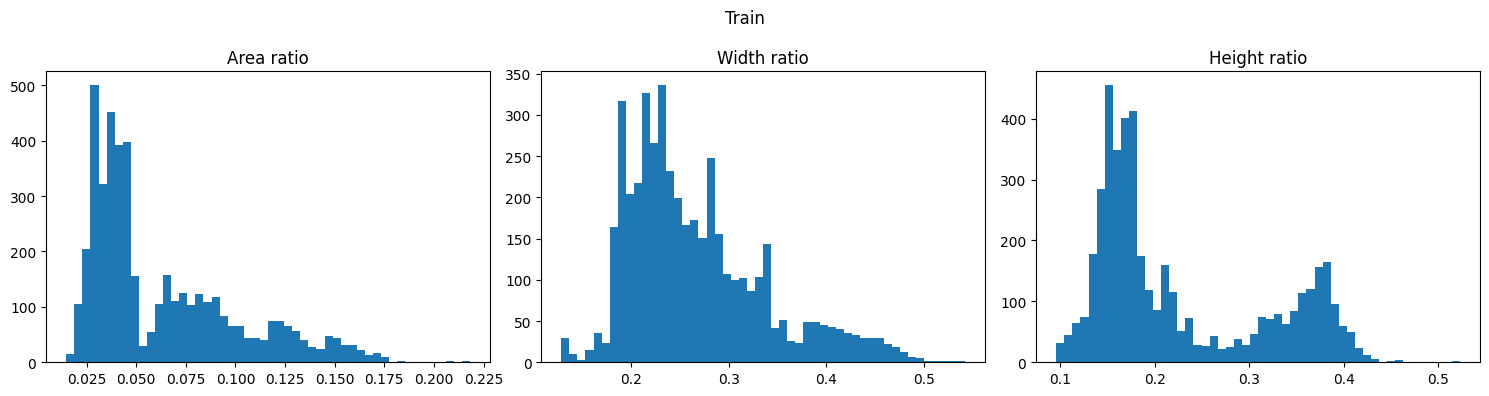


=== Test ===
bbox 개수: 5504
area mean: 0.0611
area min/max: 0.0043 / 0.4132
width mean: 0.2572
width min/max: 0.0236 / 0.5400
height mean: 0.2247
height min/max: 0.0891 / 1.7766


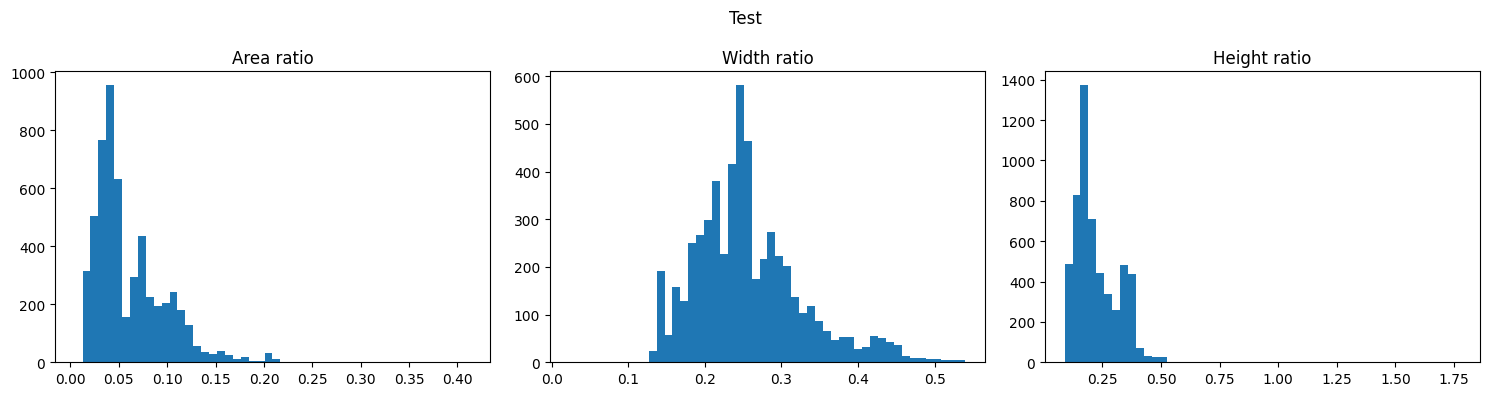

(array([0.0361072 , 0.03831487, 0.03719262, ..., 0.0505139 , 0.05247022,
        0.04944528], shape=(5504,), dtype=float32),
 array([0.2581967 , 0.2694672 , 0.2704918 , ..., 0.23258197, 0.23565574,
        0.2284836 ], shape=(5504,), dtype=float32),
 array([0.13984375, 0.1421875 , 0.1375    , ..., 0.2171875 , 0.22265625,
        0.21640626], shape=(5504,), dtype=float32))

In [5]:
#4. (NEW POLICY) bbox 크기 분포 확인
#   - 샘플 단위: JSON(약재 1개 annotation) 기준
#   - 이미지 크기(w_img,h_img)는 json["images"]에서 매칭되는 image_id로 가져옴
import numpy as np
import matplotlib.pyplot as plt

def bbox_size_distribution(json_paths, title="bbox distribution"):
    area_ratios = []
    w_ratios = []
    h_ratios = []

    for jp in json_paths:
        if not os.path.exists(jp):
            continue

        data = read_json(jp)

        img_map = {}
        for img in data.get("images", []):
            # COCO 형식: id 기반
            if "id" in img and "width" in img and "height" in img:
                img_map[img["id"]] = (img["width"], img["height"])

        for ann in data.get("annotations", []):
            bbox = ann.get("bbox")
            if not bbox or len(bbox) != 4:
                continue

            img_id = ann.get("image_id")
            if img_id not in img_map:
                continue

            w_img, h_img = img_map[img_id]
            x, y, w, h = bbox

            if w_img <= 0 or h_img <= 0:
                continue
            if w <= 0 or h <= 0:
                continue

            area_ratios.append((w * h) / (w_img * h_img))
            w_ratios.append(w / w_img)
            h_ratios.append(h / h_img)

    area_ratios = np.array(area_ratios, dtype=np.float32)
    w_ratios = np.array(w_ratios, dtype=np.float32)
    h_ratios = np.array(h_ratios, dtype=np.float32)

    print(f"\n=== {title} ===")
    print(f"bbox 개수: {len(area_ratios)}")

    if len(area_ratios) == 0:
        print("유효 bbox가 없음")
        return area_ratios, w_ratios, h_ratios

    print(f"area mean: {area_ratios.mean():.4f}")
    print(f"area min/max: {area_ratios.min():.4f} / {area_ratios.max():.4f}")
    print(f"width mean: {w_ratios.mean():.4f}")
    print(f"width min/max: {w_ratios.min():.4f} / {w_ratios.max():.4f}")
    print(f"height mean: {h_ratios.mean():.4f}")
    print(f"height min/max: {h_ratios.min():.4f} / {h_ratios.max():.4f}")

    # ===== subplot =====
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].hist(area_ratios, bins=50)
    axes[0].set_title("Area ratio")

    axes[1].hist(w_ratios, bins=50)
    axes[1].set_title("Width ratio")

    axes[2].hist(h_ratios, bins=50)
    axes[2].set_title("Height ratio")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

    return area_ratios, w_ratios, h_ratios


# =========================
# ▶ 실행 (ipynb 셀 마지막)
# (이전 단계에서 삭제가 있었으므로 재스캔 후 수행)

train_json_paths = search_json_files(TRAIN_LABEL_DIR)
test_json_paths  = search_json_files(TEST_LABEL_DIR)

bbox_size_distribution(train_json_paths, "Train")
bbox_size_distribution(test_json_paths,  "Test")

In [6]:
#4-1. (NEW POLICY) height_ratio >= thr 인 bbox를 가진 JSON 삭제
#      - JSON-level 삭제
#      - 해당 key에 JSON이 하나도 안 남으면 PNG도 삭제(orphan 처리)
import os
from datetime import datetime

def delete_large_height_bbox_jsons(json_paths, pairs, thr=0.7, log_dir="logs"):
    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(
        log_dir,
        f"deleted_height_ratio_{thr}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
    )

    deleted_json = 0
    deleted_png = 0
    log_lines = []

    # 1) 삭제 대상 JSON 수집
    target_jsons = set()

    for jp in json_paths:
        if not os.path.exists(jp):
            continue

        data = read_json(jp)

        img_map = {}
        for img in data.get("images", []):
            if "id" in img and "width" in img and "height" in img:
                img_map[img["id"]] = (img["width"], img["height"])

        delete_flag = False

        for ann in data.get("annotations", []):
            bbox = ann.get("bbox")
            if not bbox or len(bbox) != 4:
                continue

            img_id = ann.get("image_id")
            if img_id not in img_map:
                continue

            w_img, h_img = img_map[img_id]
            _, _, _, h = bbox

            if h_img > 0 and (h / h_img) >= thr:
                delete_flag = True
                break

        if delete_flag:
            target_jsons.add(jp)

    # 2) JSON 삭제 + orphan PNG 삭제
    for key, meta in pairs.items():
        jsons = meta.get("jsons", [])

        to_del = [jp for jp in jsons if jp in target_jsons]
        if not to_del:
            continue

        # JSON 삭제
        for jp in to_del:
            if os.path.exists(jp):
                os.remove(jp)
                deleted_json += 1
                log_lines.append(f"JSON DELETE: {jp}")

        # orphan PNG 삭제
        remain = [jp for jp in jsons if (jp not in target_jsons) and os.path.exists(jp)]
        if len(remain) == 0:
            png_path = meta.get("png")
            if png_path and os.path.exists(png_path):
                os.remove(png_path)
                deleted_png += 1
                log_lines.append(f"PNG DELETE (orphan): {png_path}")

    # 로그 저장
    with open(log_path, "w", encoding="utf-8") as f:
        f.write(f"삭제 JSON: {deleted_json}\n")
        f.write(f"삭제 PNG(orphan): {deleted_png}\n\n")
        f.write("\n".join(log_lines))

    print(f"삭제 완료 → JSON:{deleted_json}, PNG(orphan):{deleted_png}")
    print(f"로그 저장 → {log_path}")


# =========================
# ▶ 실행 (ipynb 셀 마지막)

# Test만 이상하다고 했으니 Test 기준 삭제
delete_large_height_bbox_jsons(test_json_paths, test_pairs, thr=0.7)

# 삭제 후 재스캔
test_json_paths = search_json_files(TEST_LABEL_DIR)
test_pairs, _ = build_pair_index(test_json_paths, TEST_RAW_DIR)

삭제 완료 → JSON:1, PNG(orphan):0
로그 저장 → logs\deleted_height_ratio_0.7_20260225_013602.txt


In [7]:
#5. (NEW POLICY) bbox가 이미지 밖으로 나간 경우 삭제 및 로그저장
#    - JSON-level 삭제
#    - 해당 key에 JSON이 하나도 안 남으면 PNG도 삭제(orphan 처리)
import os
from datetime import datetime

def delete_outside_bbox_jsons(json_paths, pairs, log_dir="logs"):
    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(
        log_dir,
        f"deleted_outside_bbox_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
    )

    # 1) 삭제 대상 JSON 수집
    target_jsons = set()

    for jp in json_paths:
        if not os.path.exists(jp):
            continue

        data = read_json(jp)

        img_map = {}
        for img in data.get("images", []):
            if "id" in img and "width" in img and "height" in img:
                img_map[img["id"]] = (img["width"], img["height"])

        delete_flag = False

        for ann in data.get("annotations", []):
            bbox = ann.get("bbox")
            if not bbox or len(bbox) != 4:
                continue

            img_id = ann.get("image_id")
            if img_id not in img_map:
                continue

            w_img, h_img = img_map[img_id]
            x, y, w, h = bbox

            # bbox가 이미지 밖
            if x < 0 or y < 0 or (x + w) > w_img or (y + h) > h_img:
                delete_flag = True
                break

        if delete_flag:
            target_jsons.add(jp)

    # 2) JSON 삭제 + orphan PNG 삭제
    deleted_json = 0
    deleted_png = 0
    log_lines = []

    for key, meta in pairs.items():
        jsons = meta.get("jsons", [])

        to_del = [jp for jp in jsons if jp in target_jsons]
        if not to_del:
            continue

        for jp in to_del:
            if os.path.exists(jp):
                os.remove(jp)
                deleted_json += 1
                log_lines.append(f"JSON DELETE: {jp}")

        remain = [jp for jp in jsons if (jp not in target_jsons) and os.path.exists(jp)]
        if len(remain) == 0:
            png_path = meta.get("png")
            if png_path and os.path.exists(png_path):
                os.remove(png_path)
                deleted_png += 1
                log_lines.append(f"PNG DELETE (orphan): {png_path}")

    # 로그 저장
    with open(log_path, "w", encoding="utf-8") as f:
        f.write(f"삭제 JSON: {deleted_json}\n")
        f.write(f"삭제 PNG(orphan): {deleted_png}\n\n")
        f.write("\n".join(log_lines))

    print(f"삭제 완료 → JSON:{deleted_json}, PNG(orphan):{deleted_png}")
    print(f"로그 저장 → {log_path}")


# =========================
# ▶ 실행 (ipynb 셀 마지막)
delete_outside_bbox_jsons(train_json_paths, train_pairs)
delete_outside_bbox_jsons(test_json_paths,  test_pairs)

# 삭제 후 재스캔
train_json_paths = search_json_files(TRAIN_LABEL_DIR)
test_json_paths  = search_json_files(TEST_LABEL_DIR)
train_pairs, _ = build_pair_index(train_json_paths, TRAIN_RAW_DIR)
test_pairs,  _ = build_pair_index(test_json_paths,  TEST_RAW_DIR)

삭제 완료 → JSON:2, PNG(orphan):0
로그 저장 → logs\deleted_outside_bbox_20260225_013604.txt
삭제 완료 → JSON:2, PNG(orphan):0
로그 저장 → logs\deleted_outside_bbox_20260225_013605.txt


In [8]:
#6. (NEW POLICY) annotation이 없는(유효 bbox 0개) JSON 삭제 및 로그저장
#    - JSON-level 삭제
#    - 해당 key에 JSON이 하나도 안 남으면 PNG도 삭제(orphan 처리)
import os
from datetime import datetime

def delete_no_annotation_jsons(json_paths, pairs, log_dir="logs"):
    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(
        log_dir,
        f"deleted_no_annotation_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
    )

    # 1) 삭제 대상 JSON 수집
    target_jsons = set()

    for jp in json_paths:
        if not os.path.exists(jp):
            continue

        data = read_json(jp)

        valid_ann = 0
        for ann in data.get("annotations", []):
            bbox = ann.get("bbox")
            if bbox and isinstance(bbox, (list, tuple)) and len(bbox) == 4:
                valid_ann += 1

        if valid_ann == 0:
            target_jsons.add(jp)

    # 2) JSON 삭제 + orphan PNG 삭제
    deleted_json = 0
    deleted_png = 0
    logs = []

    for key, meta in pairs.items():
        jsons = meta.get("jsons", [])

        to_del = [jp for jp in jsons if jp in target_jsons]
        if not to_del:
            continue

        for jp in to_del:
            if os.path.exists(jp):
                os.remove(jp)
                deleted_json += 1
                logs.append(f"JSON DELETE: {jp} (valid_ann=0)")

        remain = [jp for jp in jsons if (jp not in target_jsons) and os.path.exists(jp)]
        if len(remain) == 0:
            png_path = meta.get("png")
            if png_path and os.path.exists(png_path):
                os.remove(png_path)
                deleted_png += 1
                logs.append(f"PNG DELETE (orphan): {png_path}")

    with open(log_path, "w", encoding="utf-8") as f:
        f.write(f"삭제 JSON: {deleted_json}\n")
        f.write(f"삭제 PNG(orphan): {deleted_png}\n\n")
        f.write("\n".join(logs))

    print(f"삭제 완료 → JSON:{deleted_json}, PNG(orphan):{deleted_png}")
    print(f"로그 저장 → {log_path}")


# =========================
# ▶ 실행 (ipynb 셀 마지막)
delete_no_annotation_jsons(train_json_paths, train_pairs)
delete_no_annotation_jsons(test_json_paths,  test_pairs)

# 삭제 후 재스캔
train_json_paths = search_json_files(TRAIN_LABEL_DIR)
test_json_paths  = search_json_files(TEST_LABEL_DIR)
train_pairs, _ = build_pair_index(train_json_paths, TRAIN_RAW_DIR)
test_pairs,  _ = build_pair_index(test_json_paths,  TEST_RAW_DIR)

삭제 완료 → JSON:0, PNG(orphan):0
로그 저장 → logs\deleted_no_annotation_20260225_013607.txt
삭제 완료 → JSON:0, PNG(orphan):0
로그 저장 → logs\deleted_no_annotation_20260225_013607.txt


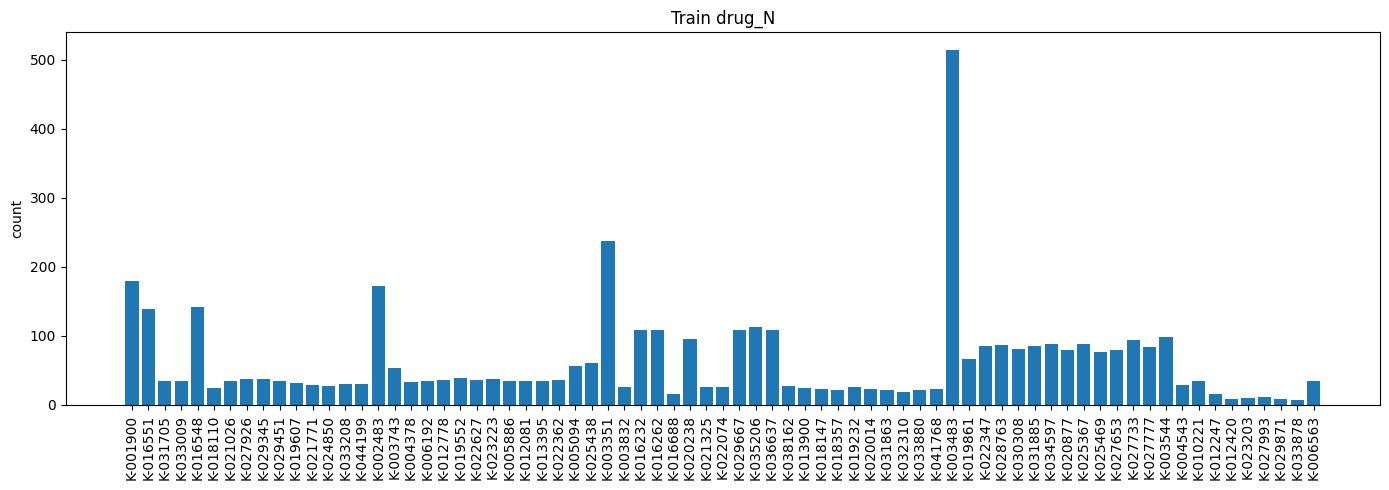

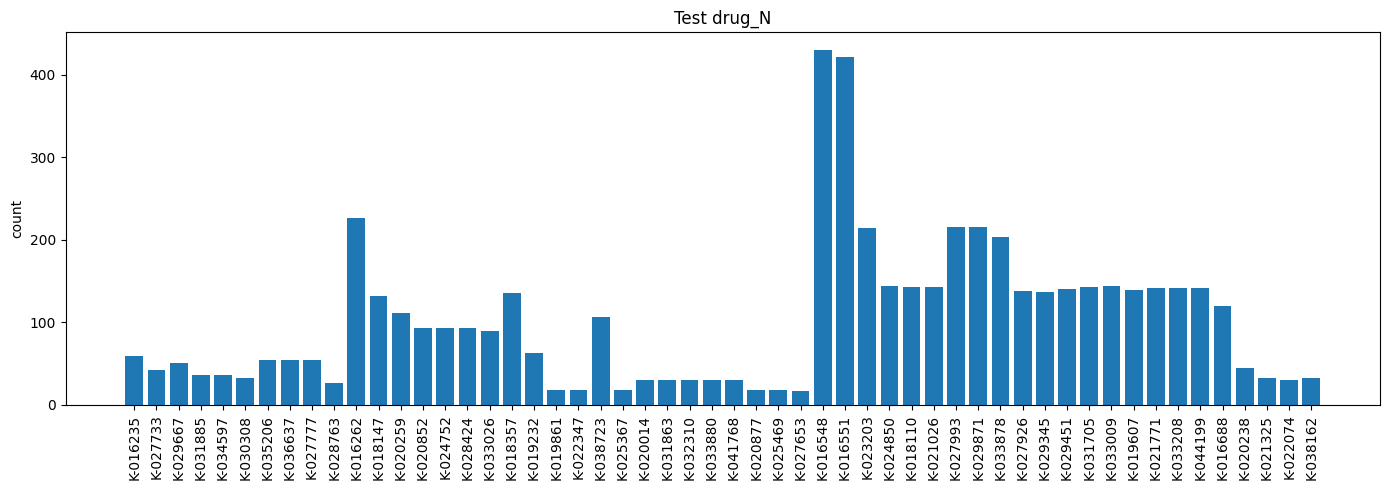


=== Train에만 있음 ===
26
['K-001900', 'K-002483', 'K-003351', 'K-003483', 'K-003544', 'K-003743', 'K-003832', 'K-004378', 'K-004543', 'K-005094', 'K-005886', 'K-006192', 'K-006563', 'K-010221', 'K-012081', 'K-012247', 'K-012420', 'K-012778', 'K-013395', 'K-013900', 'K-016232', 'K-019552', 'K-022362', 'K-022627', 'K-023223', 'K-025438']

=== Test에만 있음 ===
7
['K-016235', 'K-020259', 'K-020852', 'K-024752', 'K-028424', 'K-033026', 'K-038723']

=== 공통 클래스 ===
47


(Counter({'K-003483': 514,
          'K-003351': 237,
          'K-001900': 179,
          'K-002483': 172,
          'K-016548': 142,
          'K-016551': 139,
          'K-035206': 113,
          'K-016232': 109,
          'K-029667': 109,
          'K-016262': 108,
          'K-036637': 108,
          'K-003544': 98,
          'K-020238': 95,
          'K-027733': 94,
          'K-034597': 88,
          'K-025367': 88,
          'K-028763': 87,
          'K-022347': 85,
          'K-031885': 85,
          'K-027777': 84,
          'K-030308': 81,
          'K-020877': 80,
          'K-027653': 79,
          'K-025469': 76,
          'K-019861': 66,
          'K-025438': 61,
          'K-005094': 56,
          'K-003743': 54,
          'K-019552': 39,
          'K-027926': 38,
          'K-029345': 38,
          'K-023223': 38,
          'K-012778': 36,
          'K-022627': 36,
          'K-022362': 36,
          'K-031705': 35,
          'K-021026': 35,
          'K-005886': 35,
 

In [10]:
#7. (FINAL) 클래스 분포 + Train/Test 한쪽만 존재 클래스 표시 — drug_N 기준

import matplotlib.pyplot as plt
from collections import Counter
import os

def collect_drug_counter(json_paths):
    counter = Counter()

    for jp in json_paths:
        if not os.path.exists(jp):
            continue

        data = read_json(jp)

        drug_name = None
        for img in data.get("images", []):
            drug_name = img.get("drug_N")
            if drug_name:
                break

        if drug_name:
            counter[drug_name] += 1

    return counter


def plot_distribution(counter, title):
    labels = list(counter.keys())
    values = list(counter.values())

    plt.figure(figsize=(14,5))
    plt.bar(range(len(labels)), values)
    plt.title(title)
    plt.ylabel("count")
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.tight_layout()
    plt.show()


def compare_train_test_drug(train_json_paths, test_json_paths):

    train_counter = collect_drug_counter(train_json_paths)
    test_counter  = collect_drug_counter(test_json_paths)

    # ---- 그래프 ----
    plot_distribution(train_counter, "Train drug_N")
    plot_distribution(test_counter,  "Test drug_N")

    # ---- 비교 ----
    train_set = set(train_counter.keys())
    test_set  = set(test_counter.keys())

    only_train = sorted(train_set - test_set)
    only_test  = sorted(test_set - train_set)
    both       = sorted(train_set & test_set)

    print("\n=== Train에만 있음 ===")
    print(len(only_train))
    print(only_train[:50])

    print("\n=== Test에만 있음 ===")
    print(len(only_test))
    print(only_test[:50])

    print("\n=== 공통 클래스 ===")
    print(len(both))

    return train_counter, test_counter, only_train, only_test, both


# =========================
# ▶ 실행

train_json_paths = search_json_files(TRAIN_LABEL_DIR)
test_json_paths  = search_json_files(TEST_LABEL_DIR)

compare_train_test_drug(train_json_paths, test_json_paths)


In [11]:
#8. (FINAL POLICY) Train에 없는 drug_N을 가진 Test JSON 삭제 + orphan PNG 처리 + 로그 저장
#    - category_id 완전 미사용
#    - JSON-level 삭제
#    - 해당 key에 JSON이 하나도 안 남으면 PNG도 삭제

import os
from datetime import datetime

def delete_test_not_in_train(train_json_paths, test_json_paths, test_pairs, log_dir="logs"):
    # ---- Train drug set 수집 (JSON당 1회) ----
    train_drugs = set()
    for jp in train_json_paths:
        if not os.path.exists(jp):
            continue
        data = read_json(jp)

        drug_name = None
        for img in data.get("images", []):
            drug_name = img.get("drug_N")
            if drug_name:
                break

        if drug_name:
            train_drugs.add(drug_name)

    # ---- 로그 준비 ----
    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(
        log_dir,
        f"deleted_test_not_in_train_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
    )

    # ---- 삭제 대상 JSON 수집 (Test JSON당 1회) ----
    target_jsons = set()
    json_to_drug = {}  # 로그용

    for jp in test_json_paths:
        if not os.path.exists(jp):
            continue
        data = read_json(jp)

        drug_name = None
        for img in data.get("images", []):
            drug_name = img.get("drug_N")
            if drug_name:
                break

        if drug_name and drug_name not in train_drugs:
            target_jsons.add(jp)
            json_to_drug[jp] = drug_name

    # ---- JSON 삭제 + orphan PNG 삭제 ----
    deleted_json = 0
    deleted_png = 0
    logs = []

    for key, meta in test_pairs.items():
        jsons = meta.get("jsons", [])

        to_del = [jp for jp in jsons if jp in target_jsons]
        if not to_del:
            continue

        # JSON 삭제
        for jp in to_del:
            if os.path.exists(jp):
                os.remove(jp)
                deleted_json += 1
                logs.append(f"JSON DELETE: {jp} | drug_N={json_to_drug.get(jp)}")

        # orphan PNG 삭제 (key에 남는 JSON 0개면)
        remain = [jp for jp in jsons if (jp not in target_jsons) and os.path.exists(jp)]
        if len(remain) == 0:
            png_path = meta.get("png")
            if png_path and os.path.exists(png_path):
                os.remove(png_path)
                deleted_png += 1
                logs.append(f"PNG DELETE (orphan): {png_path}")

    # ---- 로그 저장 ----
    with open(log_path, "w", encoding="utf-8") as f:
        f.write(f"삭제 JSON: {deleted_json}\n")
        f.write(f"삭제 PNG(orphan): {deleted_png}\n\n")
        f.write("\n".join(logs))

    print(f"삭제 완료 → JSON:{deleted_json}, PNG(orphan):{deleted_png}")
    print(f"로그 저장 → {log_path}")


# =========================
# ▶ 실행 (ipynb 셀 마지막)

delete_test_not_in_train(train_json_paths, test_json_paths, test_pairs)

# 삭제 후 재스캔
test_json_paths = search_json_files(TEST_LABEL_DIR)
test_pairs, _ = build_pair_index(test_json_paths, TEST_RAW_DIR)

삭제 완료 → JSON:646, PNG(orphan):0
로그 저장 → logs\deleted_test_not_in_train_20260225_014106.txt
